# Power Outages
* **See the main project notebook for instructions to be sure you satisfy the rubric!**
* See Project 03 for information on the dataset.
* A few example prediction questions to pursue are listed below. However, don't limit yourself to them!
    * Predict the severity (number of customers, duration, or demand loss) of a major power outage.
    * Predict the cause of a major power outage.
    * Predict the number and/or severity of major power outages in the year 2020.
    * Predict the electricity consumption of an area.

Be careful to justify what information you would know at the "time of prediction" and train your model using only those features.

# Summary of Findings


### Introduction
- I want to predict the DEMAND.LOSS.MW of each outage given some features. It will a be a regression problem. The reason I chose DEMAND.LOSS.MW as my target variable is that it is an important measure of damages of outages.
- After using the baseline Model and the Final Model to predict, I will analyze the output of the final model using accuracy. If there were unfairness amongst different categories, I will analyze the cause, and whether the cause is due to randomness.


### Baseline Model
- I used a Decision Tree Regressor with five features, all of which are quantitative columns. The max_depth of the regressor is 7. During cross validation, the r-square of the model is 0.16. Obviously it's very low, so I'm not satisfied with it.

### Final Model
Added features:
* PCT_CUSTOMER: the average proportion of population who were served in a given state that year. The reason I want to add this feature is that features about customer numbers have highest correlations with DEMAND.LOSS.MW(calculated in the Baseline Model part). Therefore, I want to check whether the proportion of people connected to electricty will affect the loss.
* PCT_AFFECTED: the average proportion of population affected by outages in a given state that year. The reason I want to add this feature is that CUSTOMERS.AFFECTED has the highest correlation with DEMAND.LOSS.MW. This intuitionally makes sense because outages that affected more households will typically cause more losses. Therefore, I decided to add this feature, hoping that the proportion value can give more insight to the final model.
- Model Selction: Tested the performances of an Extra Trees Regressor and a Random Forest Regressor. I decided to choose the former one in the end.
- Model type: Extra Trees Regressor with 3 features and max_depth 6.
- I cannot know which feature works the best because One Hot Encoder added a lot of columns. The only feature that I'm sure of is 'CUSTOMER.AFFECTED' by counting it's position in the columns. You can see more detail in the section below.

### Fairness Evaluation
- For the target column values, I categorizes the losses into two categories: values above the median are 'High' and values below are 'Low'. After looking at the accuracy of the model on the two groups, I found that it performed better on the 'High' group. So I calculated the recall and the precision of the prediction and found that the proportion of negatives identified as positives(False Positive) is higher than that of positives identified as negatives(False Negative).
- Therefore, I performed a permutation test to test whether the number of False Positive is due to randomness. The result shows that the we fail to reject the hypothesis that the number of False Positive is due to randomness.

# Code

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import datetime
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

In [3]:
outage = pd.read_excel('outage.xlsx')
outage.head()

,Major power outage events in the continental U.S.,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56
0,Time period: January 2000 - July 2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Regions affected: Outages reported in this dat...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,variables,OBS,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,...,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND


## Cleaning the dataset.

The first few rows are actually introduction to the excel worksheet, and we need to get rid of them. Also the sixth row is a description of some columns, which is not part of the data. The first column consists of the labels of the indices and the columns('variables', 'Units'), which should be gotten rid of too.

In [4]:
#drop useless rows and columns
outage = outage.drop([0, 1, 2, 3, 5])
outage = outage.iloc[:, 1:]
outage.head()

,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,...,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56
4,OBS,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,...,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
6,1,2011,7,Minnesota,MN,MRO,East North Central,-0.3,normal,2011-07-01 00:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
7,2,2014,5,Minnesota,MN,MRO,East North Central,-0.1,normal,2014-05-11 00:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
8,3,2010,10,Minnesota,MN,MRO,East North Central,-1.5,cold,2010-10-26 00:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
9,4,2012,6,Minnesota,MN,MRO,East North Central,-0.1,normal,2012-06-19 00:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874


We should set the first row as the column labels and the first column as the row indices.

In [5]:
outage.columns = outage.iloc[0]
outage = outage.iloc[1:]
outage = outage.set_index('OBS', drop = True)
outage.head()

4,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,OUTAGE.START.TIME,...,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
OBS,,,,,,,,,,,,,,,,,,,,,
1,2011,7,Minnesota,MN,MRO,East North Central,-0.3,normal,2011-07-01 00:00:00,17:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
2,2014,5,Minnesota,MN,MRO,East North Central,-0.1,normal,2014-05-11 00:00:00,18:38:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
3,2010,10,Minnesota,MN,MRO,East North Central,-1.5,cold,2010-10-26 00:00:00,20:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
4,2012,6,Minnesota,MN,MRO,East North Central,-0.1,normal,2012-06-19 00:00:00,04:30:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
5,2015,7,Minnesota,MN,MRO,East North Central,1.2,warm,2015-07-18 00:00:00,02:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874


Import necessary sklearn models.

From project03 we found that many columns are missing by design. Since they are relatively small we can first drop those.

In [6]:
#drop MD
outage = outage.loc[outage['RES.PRICE'].notnull()]
outage.isnull().sum()

4
YEAR                          0
MONTH                         0
U.S._STATE                    0
POSTAL.CODE                   0
NERC.REGION                   0
CLIMATE.REGION                5
ANOMALY.LEVEL                 0
CLIMATE.CATEGORY              0
OUTAGE.START.DATE             0
OUTAGE.START.TIME             0
OUTAGE.RESTORATION.DATE      48
OUTAGE.RESTORATION.TIME      48
CAUSE.CATEGORY                0
CAUSE.CATEGORY.DETAIL       464
HURRICANE.NAMES            1440
OUTAGE.DURATION              48
DEMAND.LOSS.MW              697
CUSTOMERS.AFFECTED          437
RES.PRICE                     0
COM.PRICE                     0
IND.PRICE                     0
TOTAL.PRICE                   0
RES.SALES                     0
COM.SALES                     0
IND.SALES                     0
TOTAL.SALES                   0
RES.PERCEN                    0
COM.PERCEN                    0
IND.PERCEN                    0
RES.CUSTOMERS                 0
COM.CUSTOMERS                 0
IND.CU

Remove the names of columns and row indices.

In [7]:
outage.columns.name = None
outage.index.name = None
outage.head()

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,OUTAGE.START.TIME,...,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
1,2011,7,Minnesota,MN,MRO,East North Central,-0.3,normal,2011-07-01 00:00:00,17:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
2,2014,5,Minnesota,MN,MRO,East North Central,-0.1,normal,2014-05-11 00:00:00,18:38:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
3,2010,10,Minnesota,MN,MRO,East North Central,-1.5,cold,2010-10-26 00:00:00,20:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
4,2012,6,Minnesota,MN,MRO,East North Central,-0.1,normal,2012-06-19 00:00:00,04:30:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
5,2015,7,Minnesota,MN,MRO,East North Central,1.2,warm,2015-07-18 00:00:00,02:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874


## Filling nan values

In [8]:
outage.isnull().sum()

YEAR                          0
MONTH                         0
U.S._STATE                    0
POSTAL.CODE                   0
NERC.REGION                   0
CLIMATE.REGION                5
ANOMALY.LEVEL                 0
CLIMATE.CATEGORY              0
OUTAGE.START.DATE             0
OUTAGE.START.TIME             0
OUTAGE.RESTORATION.DATE      48
OUTAGE.RESTORATION.TIME      48
CAUSE.CATEGORY                0
CAUSE.CATEGORY.DETAIL       464
HURRICANE.NAMES            1440
OUTAGE.DURATION              48
DEMAND.LOSS.MW              697
CUSTOMERS.AFFECTED          437
RES.PRICE                     0
COM.PRICE                     0
IND.PRICE                     0
TOTAL.PRICE                   0
RES.SALES                     0
COM.SALES                     0
IND.SALES                     0
TOTAL.SALES                   0
RES.PERCEN                    0
COM.PERCEN                    0
IND.PERCEN                    0
RES.CUSTOMERS                 0
COM.CUSTOMERS                 0
IND.CUST

We need to split the target column out before fill nans, because we should not fill nans for that column.

In [9]:
#select rows that have values in DEMAND.LOSS.MW
boo_ls = [not(np.isnan(x)) for x in outage['DEMAND.LOSS.MW']]
for_pred = outage.loc[boo_ls]
len(for_pred)/len(outage)

0.5390211640211641

In [10]:
X = for_pred.drop('DEMAND.LOSS.MW', axis = 1)
display(X.head())
y = for_pred['DEMAND.LOSS.MW'].astype(int)
display(y.head())

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,OUTAGE.START.TIME,...,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
5,2015,7,Minnesota,MN,MRO,East North Central,1.2,warm,2015-07-18 00:00:00,02:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
8,2005,6,Minnesota,MN,MRO,East North Central,0.2,normal,2005-06-08 00:00:00,04:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
9,2015,3,Minnesota,MN,MRO,East North Central,0.6,warm,2015-03-16 00:00:00,07:31:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
13,2011,7,Minnesota,MN,MRO,East North Central,-0.3,normal,2011-07-08 00:00:00,10:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874
14,2011,5,Minnesota,MN,MRO,East North Central,-0.4,normal,2011-05-11 00:00:00,15:55:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5927,8.40733,5.47874


5     250
8      75
9      20
13      0
14      0
Name: DEMAND.LOSS.MW, dtype: int32

### Cleaning data: 
- fit values according to the data type of the column
- if the data type is string, then fill it with ''
- if it's numeric or datetime then fill it with the mode
- 
- In this way, we can replace nans with reasonable values and easier for latter manipulation of the data.

In [11]:
for col in X.columns:
    not_nan = X[col].loc[X[col].notnull()]
    if isinstance(not_nan.mode().iloc[0], str):
        X[col] = X[col].fillna('')
    elif (isinstance(not_nan.mode().iloc[0], np.int64) or 
            isinstance(not_nan.mode().iloc[0], np.float64) or 
            isinstance(not_nan.mode().iloc[0], int) or 
            isinstance(not_nan.mode().iloc[0], float)):
        X[col] = X[col].fillna(not_nan.mode().iloc[0])
    elif isinstance(not_nan.mode().iloc[0], datetime.datetime) or isinstance(not_nan.mode().iloc[0], datetime.time):
        X[col] = X[col].fillna(not_nan.mode().iloc[0])
X.head()

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,OUTAGE.START.TIME,...,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
5,2015,7,Minnesota,MN,MRO,East North Central,1.2,warm,2015-07-18,02:00:00,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
8,2005,6,Minnesota,MN,MRO,East North Central,0.2,normal,2005-06-08,04:00:00,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
9,2015,3,Minnesota,MN,MRO,East North Central,0.6,warm,2015-03-16,07:31:00,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
13,2011,7,Minnesota,MN,MRO,East North Central,-0.3,normal,2011-07-08,10:00:00,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
14,2011,5,Minnesota,MN,MRO,East North Central,-0.4,normal,2011-05-11,15:55:00,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743


In [12]:
X.isnull().sum()

YEAR                       0
MONTH                      0
U.S._STATE                 0
POSTAL.CODE                0
NERC.REGION                0
CLIMATE.REGION             0
ANOMALY.LEVEL              0
CLIMATE.CATEGORY           0
OUTAGE.START.DATE          0
OUTAGE.START.TIME          0
OUTAGE.RESTORATION.DATE    0
OUTAGE.RESTORATION.TIME    0
CAUSE.CATEGORY             0
CAUSE.CATEGORY.DETAIL      0
HURRICANE.NAMES            0
OUTAGE.DURATION            0
CUSTOMERS.AFFECTED         0
RES.PRICE                  0
COM.PRICE                  0
IND.PRICE                  0
TOTAL.PRICE                0
RES.SALES                  0
COM.SALES                  0
IND.SALES                  0
TOTAL.SALES                0
RES.PERCEN                 0
COM.PERCEN                 0
IND.PERCEN                 0
RES.CUSTOMERS              0
COM.CUSTOMERS              0
IND.CUSTOMERS              0
TOTAL.CUSTOMERS            0
RES.CUST.PCT               0
COM.CUST.PCT               0
IND.CUST.PCT  

In [13]:
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = X[col].astype(type(X[col].iloc[0]))
    print(col + ' : ' + str(X[col].dtype))

YEAR : int64
MONTH : int64
U.S._STATE : object
POSTAL.CODE : object
NERC.REGION : object
CLIMATE.REGION : object
ANOMALY.LEVEL : float64
CLIMATE.CATEGORY : object
OUTAGE.START.DATE : datetime64[ns]
OUTAGE.START.TIME : object
OUTAGE.RESTORATION.DATE : datetime64[ns]
OUTAGE.RESTORATION.TIME : object
CAUSE.CATEGORY : object
CAUSE.CATEGORY.DETAIL : object
HURRICANE.NAMES : object
OUTAGE.DURATION : int64
CUSTOMERS.AFFECTED : int64
RES.PRICE : float64
COM.PRICE : float64
IND.PRICE : float64
TOTAL.PRICE : float64
RES.SALES : int64
COM.SALES : int64
IND.SALES : int64
TOTAL.SALES : int64
RES.PERCEN : float64
COM.PERCEN : float64
IND.PERCEN : float64
RES.CUSTOMERS : int64
COM.CUSTOMERS : int64
IND.CUSTOMERS : int64
TOTAL.CUSTOMERS : int64
RES.CUST.PCT : float64
COM.CUST.PCT : float64
IND.CUST.PCT : float64
PC.REALGSP.STATE : int64
PC.REALGSP.USA : int64
PC.REALGSP.REL : float64
PC.REALGSP.CHANGE : float64
UTIL.REALGSP : int64
TOTAL.REALGSP : int64
UTIL.CONTRI : float64
PI.UTIL.OFUSA : float64
PO

In [14]:
X['OUTAGE.START.TIME'] = X['OUTAGE.START.TIME'].astype(datetime.time)
X['OUTAGE.START.TIME'].dtype

dtype('O')

We now need to do ordinal encoding to ordinal columns(datetime features).

In [15]:
#Ordinal Encoder
cols = ['OUTAGE.START.DATE', 'OUTAGE.START.TIME', 'OUTAGE.RESTORATION.DATE', 'OUTAGE.RESTORATION.TIME']
preproc = ColumnTransformer([('ordinal', OrdinalEncoder(), cols)], remainder = 'drop')
trans = preproc.fit_transform(X)
X[cols] = trans
display(X.head())

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,OUTAGE.START.TIME,...,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
5,2015,7,Minnesota,MN,MRO,East North Central,1.2,warm,571.0,21.0,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
8,2005,6,Minnesota,MN,MRO,East North Central,0.2,normal,112.0,45.0,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
9,2015,3,Minnesota,MN,MRO,East North Central,0.6,warm,552.0,93.0,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
13,2011,7,Minnesota,MN,MRO,East North Central,-0.3,normal,385.0,141.0,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
14,2011,5,Minnesota,MN,MRO,East North Central,-0.4,normal,362.0,283.0,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743


## Feature Selection

Next, we want to further simplify the X matrix by finding features that are most related to DEMAND.LOSS.MW.

There were lots of nan values in HURRICANE.NAMES. Though we filled it, it's probably unrelated to electricity loss, so we will just drop it.

In [16]:
X = X.drop('HURRICANE.NAMES', axis = 1)
len(X.columns)

53

We want to select features that are related to DEMAND.LOSS.MW and discard those irrelevant.

In [17]:
cor_target = X.corrwith(y).sort_values(ascending = False)
cor_target.head(10)

CUSTOMERS.AFFECTED    0.299354
IND.CUSTOMERS         0.077454
COM.SALES             0.075412
RES.SALES             0.073409
TOTAL.SALES           0.070577
RES.CUSTOMERS         0.068246
PI.UTIL.OFUSA         0.067565
TOTAL.CUSTOMERS       0.067468
TOTAL.REALGSP         0.066499
POPULATION            0.065575
dtype: float64

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,OUTAGE.START.TIME,...,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND,DEMAND.LOSS.MW
5,2015,7,Minnesota,MN,MRO,East North Central,1.2,warm,571.0,21.0,...,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,250
8,2005,6,Minnesota,MN,MRO,East North Central,0.2,normal,112.0,45.0,...,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,75
9,2015,3,Minnesota,MN,MRO,East North Central,0.6,warm,552.0,93.0,...,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,20
13,2011,7,Minnesota,MN,MRO,East North Central,-0.3,normal,385.0,141.0,...,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,0
14,2011,5,Minnesota,MN,MRO,East North Central,-0.4,normal,362.0,283.0,...,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,0


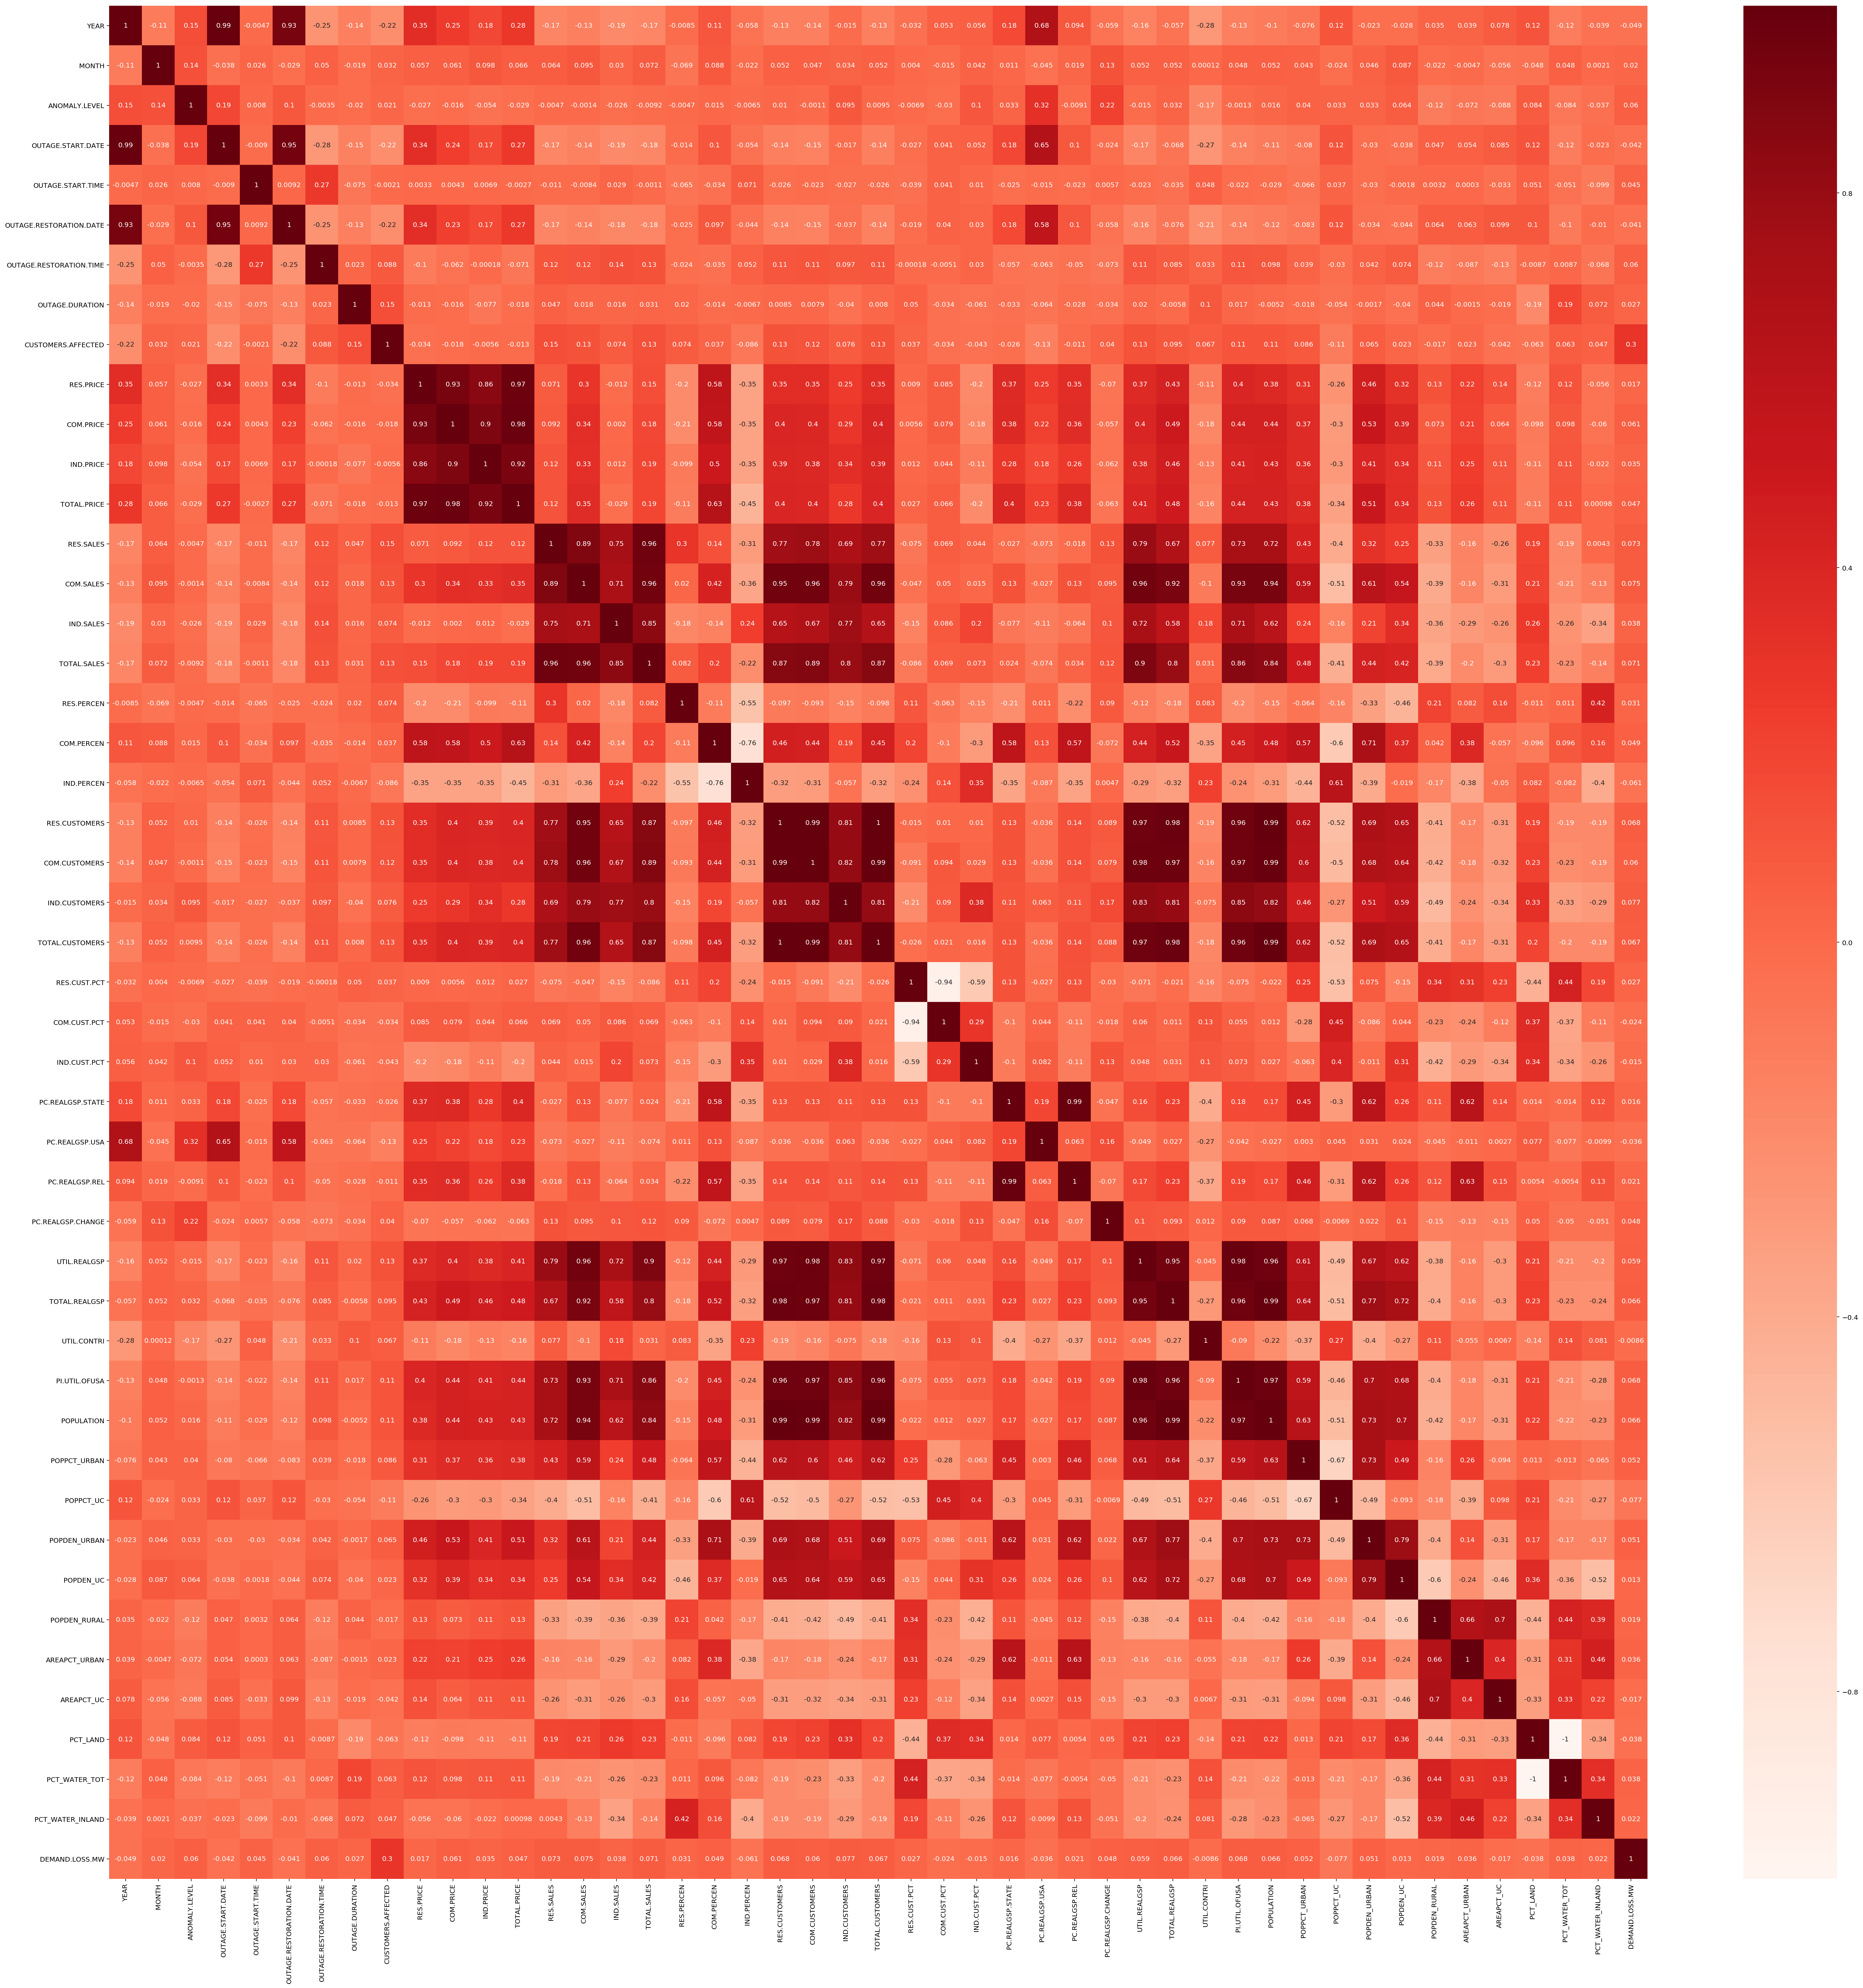

In [18]:
temp = X.merge(pd.DataFrame(y), left_index = True, right_index = True)
display(temp.head())
plt.figure(figsize=(51,51))
cor = temp.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

As you can see, most features have very low correlations with DEMAND.LOSS.MW. We will only choose features that have correlations above 0.06.

In [19]:
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.07]
relevant_features = relevant_features.index.values
relevant_features

array(['CUSTOMERS.AFFECTED', 'IND.CUSTOMERS', 'COM.SALES', 'RES.SALES',
       'TOTAL.SALES'], dtype=object)

In [20]:
select = lambda x: x in relevant_features
boo_ls = pd.Series(X.columns).apply(select).values
temp_X = X.loc[:, boo_ls]
temp_X.head()

,CUSTOMERS.AFFECTED,RES.SALES,COM.SALES,TOTAL.SALES,IND.CUSTOMERS
5,250000,2028875,2161612,5970339,9812
8,300000,1883344,1935444,5607498,8266
9,5941,1844298,1956866,5599486,9812
13,0,2332915,2114774,6562520,10673
14,0,1568544,1770802,5262668,10673


### Baseline Model

In [24]:
cols = [type(temp_X[x].iloc[0]) in [str, np.float64, np.int64] for x in temp_X.columns]
temp_X = temp_X.iloc[:, cols]
display(temp_X.head())

,CUSTOMERS.AFFECTED,RES.SALES,COM.SALES,TOTAL.SALES,IND.CUSTOMERS
5,250000,2028875,2161612,5970339,9812
8,300000,1883344,1935444,5607498,8266
9,5941,1844298,1956866,5599486,9812
13,0,2332915,2114774,6562520,10673
14,0,1568544,1770802,5262668,10673


In [77]:
X_train, X_test, y_train, y_test = train_test_split(temp_X, y)
result = []
for i in range(1, 21):
    pl = Pipeline([('model', DecisionTreeRegressor(max_depth = i))])
    pl.fit(X_train, y_train)
    result.append(pl.score(X_test, y_test))
pd.DataFrame(result)

,0
0,-0.003008
1,0.015533
2,0.002882
3,-0.020075
4,0.042697
5,0.158429
6,-0.055374
7,-0.003184
8,-0.037739
9,-0.056607


We can see that the optimal max-depth seems to be 7, but the score is very low and the variation across depths is not stable.

In [52]:
dtr = DecisionTreeRegressor(max_depth = 7)
dtr.fit(temp_X, y)
dtr.score(temp_X, y)

0.907524520885934

### Final Model

We will imporve our model by doing a better feature selection and using a different model.

Firstly, we will create two new features from the given ones.

In [27]:
X.head()

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,OUTAGE.START.TIME,...,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
5,2015,7,Minnesota,MN,MRO,East North Central,1.2,warm,571.0,21.0,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
8,2005,6,Minnesota,MN,MRO,East North Central,0.2,normal,112.0,45.0,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
9,2015,3,Minnesota,MN,MRO,East North Central,0.6,warm,552.0,93.0,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
13,2011,7,Minnesota,MN,MRO,East North Central,-0.3,normal,385.0,141.0,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
14,2011,5,Minnesota,MN,MRO,East North Central,-0.4,normal,362.0,283.0,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743


The first feature we want to engineer the how many people in a state are customers of electricity companies in percentage. To do this, we will divide the total number of customers in a state by the total population of the state. 

In [28]:
popl_by_state = X[['YEAR', 'U.S._STATE', 'TOTAL.CUSTOMERS', 'POPULATION']].groupby(['YEAR', 'U.S._STATE'])['TOTAL.CUSTOMERS', 'POPULATION'].mean()
popl_by_state.head()

TOTAL.CUSTOMERS  POPULATION
YEAR U.S._STATE                                 
2000 Arizona                 2193562     5160586
     California             12537831    33987977
     Indiana                 2865343     6091866
     New Mexico               853771     1821204
     North Carolina          4105711     8081614

In [29]:
popl_by_state['PCT_CUSTOMER'] = popl_by_state['TOTAL.CUSTOMERS'] / popl_by_state['POPULATION']
popl_by_state.head()

TOTAL.CUSTOMERS  POPULATION  PCT_CUSTOMER
YEAR U.S._STATE                                               
2000 Arizona                 2193562     5160586      0.425061
     California             12537831    33987977      0.368890
     Indiana                 2865343     6091866      0.470356
     New Mexico               853771     1821204      0.468795
     North Carolina          4105711     8081614      0.508031

In [30]:
def get_pct(ser):
    """
    A helper function to get the corresponding percentage.
    """
    year = ser.loc['YEAR']
    state = ser.loc['U.S._STATE']
    return popl_by_state.loc[year].loc[state].loc['PCT_CUSTOMER']
pcts = X[['YEAR', 'U.S._STATE']].apply(get_pct, axis = 1)
X['PCT_CUSTOMER'] = pcts
X.head()

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,OUTAGE.START.TIME,...,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND,PCT_CUSTOMER
5,2015,7,Minnesota,MN,MRO,East North Central,1.2,warm,571.0,21.0,...,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,0.487018
8,2005,6,Minnesota,MN,MRO,East North Central,0.2,normal,112.0,45.0,...,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,0.483419
9,2015,3,Minnesota,MN,MRO,East North Central,0.6,warm,552.0,93.0,...,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,0.487018
13,2011,7,Minnesota,MN,MRO,East North Central,-0.3,normal,385.0,141.0,...,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,0.485347
14,2011,5,Minnesota,MN,MRO,East North Central,-0.4,normal,362.0,283.0,...,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,0.485347


The second feature we want is the percentage of puplation affected by an outage in the state. To do this, we will divide the number of customers affected by the population in the state.

In [31]:
affected_by_state = X[['YEAR', 'U.S._STATE', 'CUSTOMERS.AFFECTED', 'POPULATION']].groupby(['YEAR', 'U.S._STATE'])['CUSTOMERS.AFFECTED', 'POPULATION'].mean()
affected_by_state['PCT_AFFECTED'] = affected_by_state['CUSTOMERS.AFFECTED'] / affected_by_state['POPULATION']
affected_by_state.head()

CUSTOMERS.AFFECTED  POPULATION  PCT_AFFECTED
YEAR U.S._STATE                                                  
2000 Arizona                    40911.0   5160586.0      0.007928
     California                 32000.0  33987977.0      0.000942
     Indiana                   124000.0   6091866.0      0.020355
     New Mexico                500000.0   1821204.0      0.274544
     North Carolina            115000.0   8081614.0      0.014230

In [32]:
def get_pct(ser):
    """
    A helper function to get the corresponding percentage.
    """
    year = ser.loc['YEAR']
    state = ser.loc['U.S._STATE']
    return affected_by_state.loc[year].loc[state].loc['PCT_AFFECTED']
pcts = X[['YEAR', 'U.S._STATE']].apply(get_pct, axis = 1)
X['PCT_AFFECTED'] = pcts
X.head()

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,OUTAGE.START.TIME,...,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND,PCT_CUSTOMER,PCT_AFFECTED
5,2015,7,Minnesota,MN,MRO,East North Central,1.2,warm,571.0,21.0,...,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,0.487018,0.023311
8,2005,6,Minnesota,MN,MRO,East North Central,0.2,normal,112.0,45.0,...,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,0.483419,0.058598
9,2015,3,Minnesota,MN,MRO,East North Central,0.6,warm,552.0,93.0,...,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,0.487018,0.023311
13,2011,7,Minnesota,MN,MRO,East North Central,-0.3,normal,385.0,141.0,...,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,0.485347,0.000000
14,2011,5,Minnesota,MN,MRO,East North Central,-0.4,normal,362.0,283.0,...,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,0.485347,0.000000


In [33]:
X_train.head()

,CUSTOMERS.AFFECTED,RES.SALES,COM.SALES,TOTAL.SALES,IND.CUSTOMERS
1193,859554,7602646,10914120,22723895,76223
973,0,4847159,7098612,13692504,7630
1373,0,161143,167354,443915,221
1128,0,6527290,8008690,21351409,84189
16,0,3400800,2993975,8258806,1245


## Feature Selection

We will first use an Extra Trees Regressor to do feature selection and prediction.

In [34]:
#One Hot Encoder
boo_ls = [X[col].dtype == 'object' for col in X.columns]
cols = X.columns[boo_ls]
col_trans = ColumnTransformer([('one_hot', OneHotEncoder(), cols)], remainder = 'passthrough')
col_trans

ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('one_hot',
                                 OneHotEncoder(categorical_features=None,
                                               categories=None, drop=None,
                                               dtype=<class 'numpy.float64'>,
                                               handle_unknown='error',
                                               n_values=None, sparse=True),
                                 Index(['U.S._STATE', 'POSTAL.CODE', 'NERC.REGION', 'CLIMATE.REGION',
       'CLIMATE.CATEGORY', 'CAUSE.CATEGORY', 'CAUSE.CATEGORY.DETAIL'],
      dtype='object'))],
                  verbose=False)

To make sure that we can split the dataset into training set and test set, we first replace categories in string features that appeared less than 10 times with 'other'.

In [35]:
for col in cols:
    ser = X[col].value_counts()
    replace = lambda x: 'other' if ser.loc[x] < 10 else x
    ls = X[col].apply(replace)
    X[col] = ls
X[cols].head()

,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,CLIMATE.CATEGORY,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL
5,other,other,MRO,East North Central,warm,severe weather,
8,other,other,MRO,East North Central,normal,severe weather,thunderstorm
9,other,other,MRO,East North Central,warm,intentional attack,sabotage
13,other,other,MRO,East North Central,normal,intentional attack,vandalism
14,other,other,MRO,East North Central,normal,intentional attack,vandalism


C:\Users\QYK\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


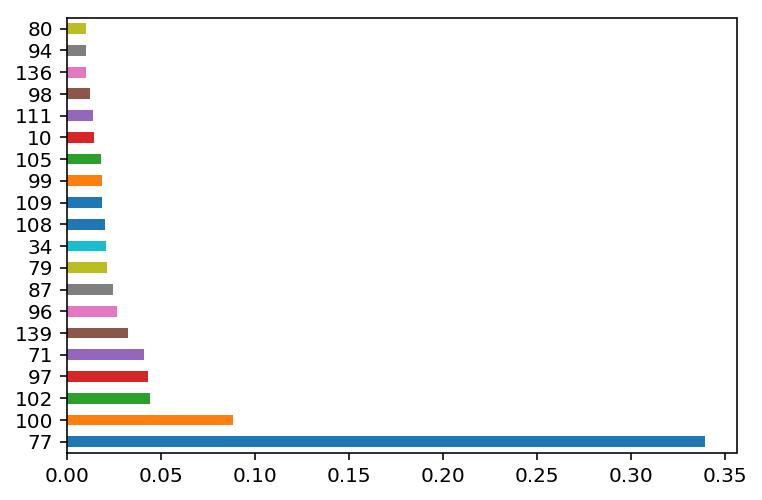

In [36]:
pl = Pipeline([('preprocessing', col_trans), ('feature_select', ExtraTreesRegressor())])
pl.fit(X, y)
pd.Series(pl['feature_select'].feature_importances_).nlargest(20).plot(kind = 'barh')

There are 140 columns, 85 of which are newly created by the one hot encoder, so we cannot know exactly which column are they. We can only be sure that the third highest feature is CUSTOMERS.AFFECTED, because it's behind all categorical features and it's 40th column counting from the last column.

In [37]:
len(col_trans.transform(X)[0])

140

In [38]:
print(len(X.columns))
X.columns[15]

55


'CUSTOMERS.AFFECTED'

Except one column, all other features have pretty low importances. In the next cell, I plotted the residual graphs of Extra Trees Regressors with various numbers of estimators, and found that they are all very bad and the error are very unstable. So I decided to just pick 3 as the number of estimators, because the fourth feature has a much lower importance level than the third one.

,0,1
0,1843.946050,0.063100
1,3796.165050,0.004323
2,3034.528261,0.035379
3,3171.682027,0.021405
4,2791.761351,-0.112623
5,1015.519544,0.426390
6,2691.454034,0.025159
7,1245.728432,0.248238
8,3348.417256,-0.064551
9,3914.922363,-0.515325


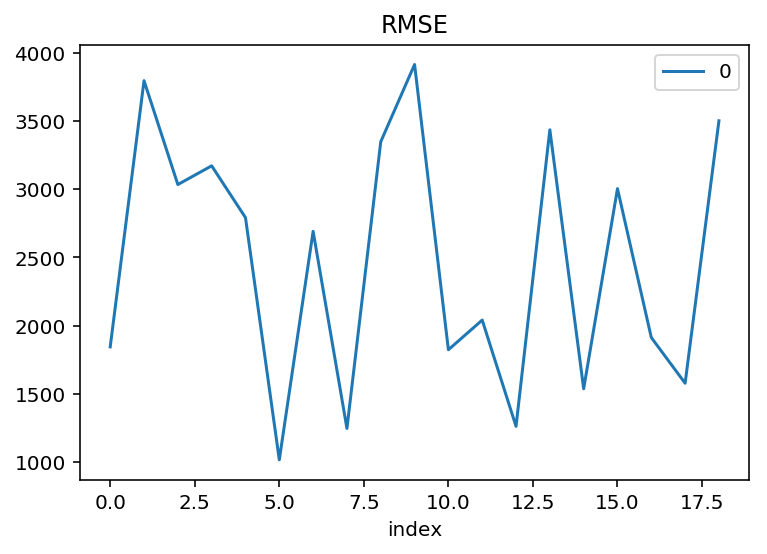

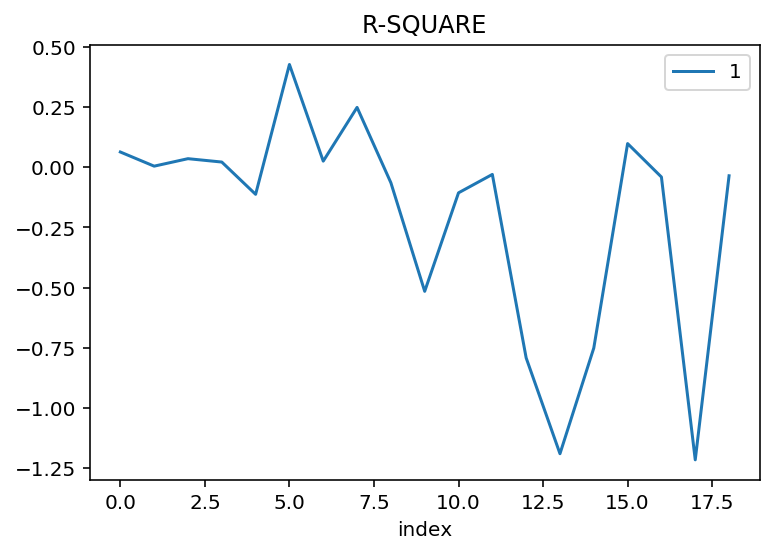

In [139]:
result = []
for i in range(1, 20):
    rmse_r2 = []
    pl = Pipeline([('preprocessing', col_trans), ('feature_select', ExtraTreesRegressor(n_estimators = 3, max_depth = i))])
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    pl.fit(X_train, y_train)
    
    #calculate rmse
    pred = pl.predict(X_test)
    rmse_r2.append(np.sqrt(np.mean((pred - np.array(y_test))**2)))
    
    #get the r-square score
    rmse_r2.append(pl.score(X_test, y_test))
    result.append(rmse_r2)
result = pd.DataFrame(result)
display(result.head(10))
result.reset_index().plot(x = 'index', y = 0, title = 'RMSE')
result.reset_index().plot(x = 'index', y = 1, title = 'R-SQUARE')

We can see that the errors are still very unstable, probably because there's no good features to predict the demand loss. We will just choose 6 as our max_depth.

The second we will consider will be a random forest. We will use 8 features to predict, same as the extra trees regressor. And we will test for the best max_depth using a for loop.

,0,1
0,3447.025154,0.001566
1,3210.520917,-0.037549
2,2350.862479,-0.367567
3,3193.296842,-2.578860
4,2332.548700,-2.454411
5,3865.220950,-7.320695
6,1900.882493,0.115666
7,4357.023082,-13.656547
8,1445.499595,-0.235164
9,1850.627589,0.063951


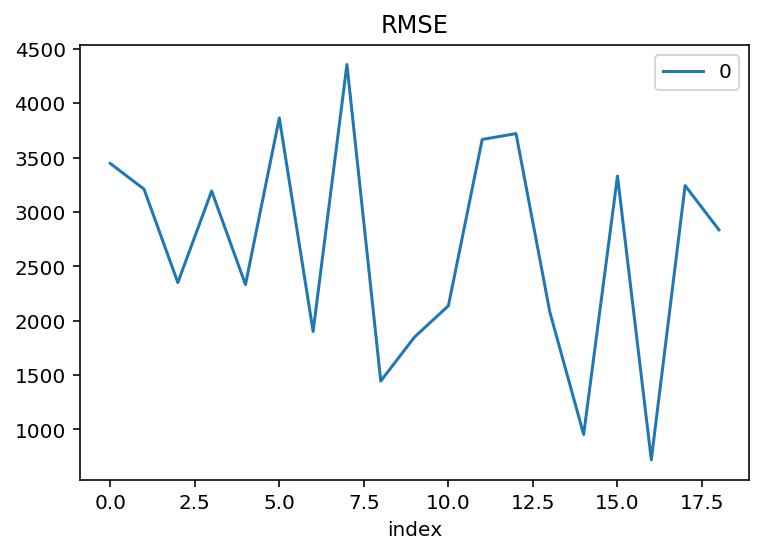

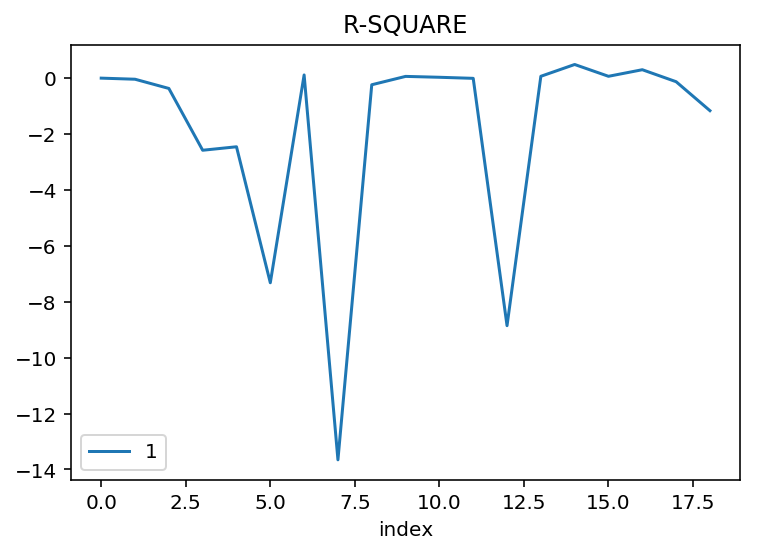

In [152]:
result = []
for i in range(1, 20):
    rmse_r2 = []
    pl = Pipeline([('preprocessing', col_trans), ('feature_select', RandomForestRegressor(n_estimators = 3, max_depth = i))])
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    pl.fit(X_train, y_train)
    
    #calculate rmse
    pred = pl.predict(X_test)
    rmse_r2.append(np.sqrt(np.mean((pred - np.array(y_test))**2)))
    
    #get the r-square score
    rmse_r2.append(pl.score(X_test, y_test))
    result.append(rmse_r2)
result = pd.DataFrame(result)
display(result.head(20))
result.reset_index().plot(x = 'index', y = 0, title = 'RMSE')
result.reset_index().plot(x = 'index', y = 1, title = 'R-SQUARE')

We can see that this model is actually also very unstable and its r-square values are even worse than those of the Extra Trees Regressor. Therefore, we will choose the Extra Trees Regressor as our final model.

In [175]:
pl = Pipeline([('preprocessing', col_trans), ('feature_select', ExtraTreesRegressor(n_estimators = 3, max_depth = 6))])
pl.fit(X, y)
pl.score(X, y)

0.8580346753154133

In [176]:
#the prediction out of the final model
pred = pl.predict(X)
len(pred)

815

### Fairness Evaluation

For the DEMAND.LOSS.MW column, We will classify values above the median as 'High' and below the median as 'Low'. Then we can analysis the parity of our model on that.

In [177]:
classify = lambda x: 1 if x > np.median(y) else 0
real_ls = y.apply(classify).reset_index(drop = True)
pred_ls = pd.Series(pred).apply(classify)
display(real_ls.head())
display(pred_ls.head())

0    1
1    0
2    0
3    0
4    0
Name: DEMAND.LOSS.MW, dtype: int64

0    1
1    1
2    0
3    0
4    0
dtype: int64

Append the classfied column and the prediction to y.

In [178]:
y_df = pd.DataFrame()
y_df['CLASSIFIED'] = real_ls
y_df['PREDICTION'] = pred_ls
y_df.head()

,CLASSIFIED,PREDICTION
0,1,1
1,0,1
2,0,0
3,0,0
4,0,0


In [179]:
y_high = y_df.loc[y_df['CLASSIFIED'] == 1]
y_low = y_df.loc[y_df['CLASSIFIED'] == 0]
display(y_high.head())
display(y_low.head())

,CLASSIFIED,PREDICTION
0,1,1
5,1,1
8,1,1
9,1,1
11,1,1


,CLASSIFIED,PREDICTION
1,0,1
2,0,0
3,0,0
4,0,0
6,0,1


Since the two categories(high and low) have very close length, we can first calculate their respective accuracy for a general picture of the model's performace.

In [180]:
#accuracy by groups
high_acc = accuracy_score(y_high['CLASSIFIED'], y_high['PREDICTION'])
low_acc = accuracy_score(y_low['CLASSIFIED'], y_low['PREDICTION'])
(high_acc, low_acc)

(0.9926289926289926, 0.4534313725490196)

It seems that the model performs better on high loss values. To further analyze the cause of the difference, we will analyze their recall and precision values.

In [181]:
#recall
recall = recall_score(y_df['CLASSIFIED'], y_df['PREDICTION'])
recall

0.9926289926289926

A really high proportion of positives(High losses) are correcly identified.

In [182]:
#precision
prec = precision_score(y_df['CLASSIFIED'], y_df['PREDICTION'])
prec

0.6443381180223285

The precision score is lower than the recall. As we look back at the fomulas for them, their numerators are actually the same. The difference must resulted from (False Negative < False Positive). Therefore, the accuracy error is caused by a higher proportion of negatives(Low losses) identified as positive.

We will construct a permuation test to test the difference between False Positive and False Negative with alpha = 0.05. The null hypothesis is that they are the same(diff = 0), and the alternative hypothesis is that there's a difference.

In [183]:
#observed value
tn, fp, fn, tp = confusion_matrix(y_df['CLASSIFIED'], y_df['PREDICTION']).ravel()
obs = fp
obs

223

In [184]:
result = []
temp = y_df
for i in range(100):
    temp['CLASSIFIED'] = y_df['CLASSIFIED'].sample(frac = 1, replace = False).reset_index(drop = True)
    tn, fp, fn, tp = confusion_matrix(temp['CLASSIFIED'], temp['PREDICTION']).ravel()
    result.append(fp)
p_val = np.mean(np.array(result) >= obs)
p_val

1.0

Since the p value is larger than 0.05, we fail to reject the null hypothesis.